# Nipams SimplestRun

# 0. Initialize

In [1]:
#@title Connect to gDrive & Load Files
ENV_COLAB = 'google.colab' in str(get_ipython())
if ENV_COLAB:
    print('Running on CoLab')
    PROJECT_DRIVE_FOLDER= "/content/drive/MyDrive/NiPAMS/BP development/analysis/nipams-bp-py-main/" #@param {"type":"string"}
    ## Load this for local development version of library.. Loads from GoogleDrive (changes persist)
    from google.colab import drive, widgets, data_table; 
    drive.mount('/content/drive');
    %cd "$PROJECT_DRIVE_FOLDER"
  
    !pip install -qr requirements.txt
    !pip install -q envyaml
    import os, sys; 
    from envyaml import EnvYAML; env = EnvYAML('.env/default.yaml'); 
    for k,v in env.export().items(): os.environ[k]=str(v)
    sys.path.append(os.path.abspath("./src"))

else:
    print('Not running on CoLab')
    %cd /app
!pwd

from importlib import reload;
from utils.constants import *

Not running on CoLab
/app
/app


In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Connect & Load Data

In [3]:
from data import load_data; reload(load_data)

dfBpAll, dfImuAll = load_data.load_dataframe_from_mat(folder='data/raw_mat/', pattern='LLV')

# 2. Process Signal Data in Heartbeats

In [4]:
from data import preprocess; reload(preprocess)

dfAll = preprocess.merge_imu_vcg_with_heartbeats(dfBpAll, dfImuAll)

# 3. Define Data Splits (Patients, Heartbeats, etc)

In [5]:
from models import experiments; reload(experiments);

dfImu = dfAll[INDICIES + IMU_COLS]
dfBp = dfAll[INDICIES + BP_COLS]

sampleRandTestInds = experiments.split_by_random(dfImu, dfBp)
sampleExpDfs = experiments.get_experiment(sampleRandTestInds[0], dfImu, dfBp)

# 4. Modeling Pipelines (Baselines & Analytical)

## Initialize Pipelines

In [6]:
import sklearn
from sklearn.pipeline import Pipeline

from features import tsfel_vectorizer, simple as features_simple

tsExplodeTransform = preprocess.FunctionTransformer(partial(preprocess.explode_3d, data_cols=['az','ax']))
tsVectorizeSimpleTransform = preprocess.FunctionTransformer(partial(features_simple.vectorize_mean_std))
tsVectorLookupTransform = preprocess.FunctionTransformer(partial(features_simple.vectorize_mean_std))

from models import baselines, analytical_mvd

pipe_random = Pipeline([('transform', tsExplodeTransform), ('model', baselines.RandomRegressor())])
pipe_mean = Pipeline([('transform', tsExplodeTransform), ('model', baselines.DummyRegressor())])
pipe_vect_simple = Pipeline([('transform', tsVectorizeSimpleTransform), ('model', sklearn.ensemble.RandomForestRegressor())])
# pipe_mvd = Pipeline([('scaler', tsExplodeTransform), ('rand', analytical_mvd.AnalyticalBPEstimator())])     ##TODO : Has a bug.. I think interpolation is broken?

In [7]:
from features import tsfel_vectorizer; reload(tsfel_vectorizer)
from sklearn import feature_selection

tsVectorLookupTransform = preprocess.FunctionTransformer(partial(features_simple.vectorize_mean_std))
# dfVects = pd.read_feather('data/vectors/dfImuVects-LLV.feather')
# tsVectorLookupTransform = sklearn.preprocessing.FunctionTransformer(tsfel_vectorizer.VectorLookup(dfVects))

pipe_vect_tsfel = Pipeline([
    ('transform', tsVectorLookupTransform), 
    ('feature_selection_simple', feature_selection.VarianceThreshold()),
    ('feature_selection', feature_selection.SelectFromModel(sklearn.linear_model.LinearRegression())),
    ('model', sklearn.ensemble.GradientBoostingRegressor())])

## Train Model Pipelines

In [8]:
from sklearn.metrics import mean_absolute_error

for pipe in [pipe_vect_tsfel, pipe_random, pipe_mean, pipe_vect_simple]:
    pipe.fit(sampleExpDfs['train_x'], sampleExpDfs['train_y'].groupby(INDICIES)['sbp'].mean())
    score = mean_absolute_error(
        pipe.predict(sampleExpDfs['test_x']),
        sampleExpDfs['test_y'].groupby(INDICIES)['sbp'].mean()
    )
    print('Achieved Score (MAE) : ', score, pipe)

Achieved Score (MAE) :  3.0303108463020427 Pipeline(steps=[('transform',
                 FunctionTransformer(func=functools.partial(<function vectorize_mean_std at 0x7fe3b06ea310>))),
                ('feature_selection_simple', VarianceThreshold()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', GradientBoostingRegressor())])
Achieved Score (MAE) :  9.489110597126768 Pipeline(steps=[('transform',
                 FunctionTransformer(func=functools.partial(<function explode_3d at 0x7fe3b9242790>, data_cols=['az', 'ax']))),
                ('model',
                 <models.baselines.RandomRegressor object at 0x7fe3b05ca280>)])
Achieved Score (MAE) :  6.64039434866914 Pipeline(steps=[('transform',
                 FunctionTransformer(func=functools.partial(<function explode_3d at 0x7fe3b9242790>, data_cols=['az', 'ax']))),
                ('model', DummyRegressor())])
Achieved Score (MAE) :  2.05097975581

# 5. Evaluation

In [9]:
pipe = pipe_vect_simple

train_y = sampleExpDfs['train_y'].groupby(INDICIES)['dbp'].mean()
test_y = sampleExpDfs['test_y'].groupby(INDICIES)['dbp'].mean()

pipe.fit(sampleExpDfs['train_x'], train_y)
preds = pipe.predict(sampleExpDfs['test_x'])

score_mae = mean_absolute_error(preds, test_y)
print('Achieved Score (MAE) : ', score)

Achieved Score (MAE) :  2.0509797558135707


<AxesSubplot: xlabel='target', ylabel='preds'>

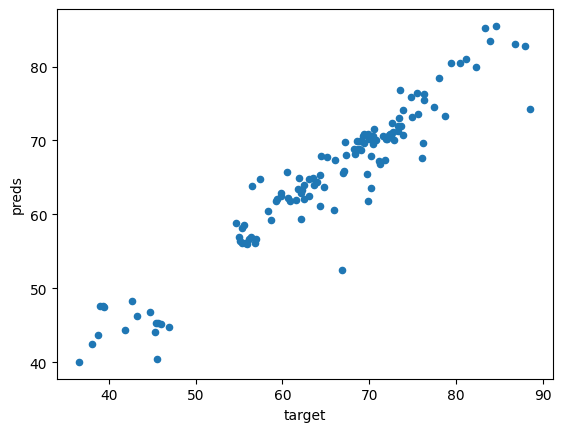

In [10]:
pd.DataFrame([preds, test_y], ['preds','target']).T.plot.scatter(1,0)